In [ ]:
# Mouting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import datetime
import gc
import pickle

import PIL.Image as Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import layers
from keras.callbacks import *
from keras.models import Sequential, Model, load_model
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.math import confusion_matrix

%load_ext tensorboard

In [ ]:
batchSize = 32
imageHeight = 224
imageWidth = 224
randomisingSeed = 108
colorMode = "rgb"
validationSplitFraction = 0.2
imageInterpolationMethod  = "bilinear"
cropToPreserveAspectRatioWhileResizing = False

augmentDataset = True
cropBottomPanel = False

earlyStoppingMetric = "val_accuracy"
earlyStoppingMinimumImprovementCriterion = 0.01
earlyStoppingPatience = 5

baselineAccuracy = 0.5

learningRateReductionMetric = 'val_loss'
patienceForLearningRateReduction = 10
learningRateReductionFactor = 0.1
learningRateReductionMinimumImprovementCriterion = 0.0001
learningRateReductionCooldown = 25
minimumLearningRate = 0

useTensorboard = True

useArchitecture = ['customCNN', 'ResNetTransfer'][1]
doSeperateFineTuning = False
makeTransferModelTrainable = False
addConvolutionLayersOnBaseModel = True

maxPoolingSize = (2, 2)
maxPollingPadding = 'valid'

convolutionKernelSize = 3
convolutionKernelRegulariser = None
convolutionActivityRegulariser = None

In [ ]:
# Daatset locations on G drive
# Make sure that the daatset folder is there in drive
# And that a seeprate tmpModelBackup folder has been created for each model that runs at a given time
datasetName = 'SEM100'
modelName = 'NamamOptimser_LabelEncoded_simpleTransferLearning_InceptionResnet_V2_rgb_notCropped_augemnted_learningRateReduction10x_seed108_restDefault'
trainingDataPath = '/content/drive/MyDrive/SEMProject/' + datasetName + '/train'
testingDataPath = '/content/drive/MyDrive/SEMProject/' + datasetName + '/test'
historySaveLocation = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/history/' + modelName + 'data.pickle'
fineTuneHistorySaveLocation = '/content/drive/My Drive/' + datasetName + '/models/history/' + modelName + '_fineTune_data.pickle'
modelSaveLocation = '/content/drive/MyDrive/SEMProject/SEM100/models/finalModels/' + modelName + '.h5'
fineTuneModelSaveLocation = '/content/drive/MyDrive/SEMProject/SEM100/models/finalModels/' + modelName + '_fineTune.h5'

rootLogsDirectory = '/content/drive/MyDrive/SEMProject/' + datasetName + "/logs/"

In [ ]:
def getDataset(batchSize, imageHeight, imageWidth, randomisingSeed, colorMode, validationSplitFraction, imageInterpolationMethod, cropToPreserveAspectRatioWhileResizing, augmentDataset, cropBottomPanel):
  trainingDataset, validationDataset = tf.keras.utils.image_dataset_from_directory(
      directory = trainingDataPath,
      labels = "inferred",
      label_mode = "categorical",
      color_mode = colorMode,
      batch_size = batchSize,
      image_size = (imageHeight, imageWidth),
      seed = randomisingSeed,
      shuffle = True,
      validation_split = validationSplitFraction,
      subset="both",
      interpolation = imageInterpolationMethod,
      crop_to_aspect_ratio = cropToPreserveAspectRatioWhileResizing
      )

  testingDataset = tf.keras.utils.image_dataset_from_directory(
    directory = testingDataPath,
    labels = 'inferred',
    label_mode = "categorical",
    color_mode = colorMode,
    batch_size = batchSize,
    image_size = (imageHeight, imageWidth),
    seed=  randomisingSeed,
    shuffle = True,
    interpolation = imageInterpolationMethod,
    crop_to_aspect_ratio = cropToPreserveAspectRatioWhileResizing
    )

  classNames = np.array(trainingDataset.class_names)
  print(classNames)

  def cropBottomPanel(image, label):
    return tf.image.crop_and_resize(image = image , boxes = np.array( [[0, 0, 600/768, 1]] ) ,box_indices = [0], crop_size = (imageHeight, imageWidth), method = imageInterpolationMethod,extrapolation_value = 0.0,name = None), label

  #if cropBottomPanel:
    #trainingDataset = trainingDataset.map(cropBottomPanel)
    #validationDataset = validationDataset.map(cropBottomPanel)
    #testingDataset = testingDataset.map(cropBottomPanel)
    #imageHeight = int(imageHeight * 600/ 768)

  augmentedTrainingDataset = trainingDataset

  if augmentDataset:
    dataAugmentation = keras.Sequential(
        [
            layers.RandomRotation(factor = (-0.5, 0.5), fill_mode = "nearest", interpolation = imageInterpolationMethod, seed = randomisingSeed),
            layers.RandomFlip(mode = "horizontal_and_vertical", seed = randomisingSeed),
            layers.RandomTranslation(height_factor = (-0.2, 0.2), width_factor = (-0.2, 0.2), fill_mode = "nearest", interpolation = imageInterpolationMethod, seed = randomisingSeed),
            layers.RandomZoom(height_factor = (-0.3, 0.3), width_factor = (-0.2, 0.2), fill_mode = "nearest", interpolation = imageInterpolationMethod, seed = randomisingSeed),
            layers.RandomContrast(factor = (0.4, 0.3), seed = randomisingSeed)
        ]
    )

    augmentedTrainingDataset = trainingDataset.map(lambda x, y: (dataAugmentation(x), y))

  AUTOTUNE = tf.data.AUTOTUNE

  if augmentDataset:
    augmentedTrainingDataset = augmentedTrainingDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  else:
    trainingDataset = trainingDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

  validationDataset = validationDataset.cache().prefetch(buffer_size=AUTOTUNE)

  return trainingDataset, augmentedTrainingDataset, validationDataset, testingDataset, classNames, imageHeight

In [ ]:
trainingDataset, augmentedTrainingDataset, validationDataset, testingDataset, classNames, imageHeight = getDataset(batchSize = batchSize,
                                                                                                      imageHeight = imageHeight, imageWidth = imageWidth,
                                                                                                      randomisingSeed = randomisingSeed,
                                                                                                      colorMode = colorMode,
                                                                                                      validationSplitFraction = validationSplitFraction,
                                                                                                      imageInterpolationMethod = imageInterpolationMethod,
                                                                                                      cropToPreserveAspectRatioWhileResizing = cropToPreserveAspectRatioWhileResizing,
                                                                                                      augmentDataset = augmentDataset, cropBottomPanel = cropBottomPanel)

Found 1223 files belonging to 10 classes.
Using 979 files for training.
Using 244 files for validation.
Found 319 files belonging to 10 classes.
['Biological' 'Fibres' 'Films_Coated_Surface'
 'MEMS_devices_and_electrodes' 'Nanowires' 'Particles' 'Patterned_surface'
 'Porous_Sponge' 'Powder' 'Tips']


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
trainingDataset = trainingDataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
augmentedTrainingDataset = augmentedTrainingDataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
validationDataset = validationDataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
testingDataset = testingDataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
trainingDataset = trainingDataset.cache().prefetch(buffer_size=AUTOTUNE)
augmentedTrainingDataset = augmentedTrainingDataset.cache().prefetch(buffer_size=AUTOTUNE)
validationDataset = validationDataset.cache().prefetch(buffer_size=AUTOTUNE)
testingDataset = testingDataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for imagesBatch, labelsBatch in trainingDataset:
  print(imagesBatch.shape)
  print(labelsBatch.shape)
  break

(32, 224, 224, 3)
(32, 10)


### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
InceptionResnet_V2 = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5"
featureExtractorModel = InceptionResnet_V2 #@param ["mobilenet_v2", "inception_v3", "InceptionResnet_V2"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    featureExtractorModel,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [ ]:
feature_batch = feature_extractor_layer(imagesBatch)
print(feature_batch.shape)

(32, 1001)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [ ]:
numberOfClasses = len(classNames)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(numberOfClasses)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              55875273  
                                                                 
 dense (Dense)               (None, 10)                10020     
                                                                 
Total params: 55,885,293
Trainable params: 10,020
Non-trainable params: 55,875,273
_________________________________________________________________


In [ ]:
predictions = model(imagesBatch)

In [ ]:
predictions.shape

TensorShape([32, 10])

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Nadam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

log_dir = rootLogsDirectory + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
def getCallbacks(datasetName, modelName, earlyStoppingMetric, earlyStoppingMinimumImprovementCriterion, earlyStoppingPatience,
                 baselineAccuracy,
                 learningRateReductionMetric, learningRateReductionFactor, patienceForLearningRateReduction,
                 learningRateReductionMinimumImprovementCriterion, learningRateReductionCooldown):
  callbackList = []

  callbackList.append(BackupAndRestore(backup_dir = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/tmpModelBackup/' + modelName + 'epoch_{epoch:04d}.h5', save_freq = 'epoch',
                                    delete_checkpoint = True, save_before_preemption = False))

  callbackList.append(EarlyStopping(monitor = earlyStoppingMetric, min_delta = earlyStoppingMinimumImprovementCriterion, patience = earlyStoppingPatience,
                                    verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True, start_from_epoch = 0))

  #def learningrateSchedule(currentEpochNumber, learningRatefromPreviousEpoch):
  #  learningRateForCurrentEpoch = learningRatefromPreviousEpoch
  #  return learningRateForCurrentEpoch

  #callbackList.append(LearningRateScheduler(learningRateSchedule(epoch, lr), verbose = 1))

  #callbackList.append(ModelCheckpoint(filepath = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/allTrainingModels/' + modelName + 'epoch_{epoch:04d}.h5',
  #                                    monitor = 'val_loss', verbose = 1, save_best_only = False, save_weights_only = False, mode = 'auto', save_freq = 'epoch',
  #                                    options = None, initial_value_threshold = None))
  callbackList.append(ModelCheckpoint(filepath = '/content/drive/My Drive/SEMProject' + datasetName + '/models/finalModels/' + modelName + 'MostAccurateEpoch_{epoch:04d}.h5',
                                      monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 'epoch',
                                      options = None, initial_value_threshold = baselineAccuracy))
  callbackList.append(ModelCheckpoint(filepath = '/content/drive/My Drive/SEMProject' + datasetName + '/models/finalModels/' + modelName + 'LeastLossEpoch_{epoch:04d}.h5',
                                      monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 'epoch',
                                      options = None, initial_value_threshold = None))

  callbackList.append(ReduceLROnPlateau(monitor = learningRateReductionMetric, factor = learningRateReductionFactor, patience = patienceForLearningRateReduction,
                                        verbose = 1, mode='auto', min_delta = learningRateReductionMinimumImprovementCriterion, cooldown = learningRateReductionCooldown,
                                        min_lr = minimumLearningRate))

  callbackList.append(TerminateOnNaN())

  callbackList.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))

  return callbackList

In [ ]:
NUM_EPOCHS = 30

history = model.fit(trainingDataset,
                    validation_data=validationDataset,
                    epochs=NUM_EPOCHS,
                    callbacks=getCallbacks(datasetName, modelName, earlyStoppingMetric, earlyStoppingMinimumImprovementCriterion, earlyStoppingPatience,
                                           baselineAccuracy, learningRateReductionMetric, learningRateReductionFactor, patienceForLearningRateReduction,
                                           learningRateReductionMinimumImprovementCriterion, learningRateReductionCooldown))

Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 2.6025 - accuracy: 0.3156
Epoch 1: val_accuracy improved from 0.50000 to 0.58197, saving model to /content/drive/My Drive/SEMProjectSEM100/models/finalModels/NamamOptimser_LabelEncoded_simpleTransferLearning_InceptionResnet_V2_rgb_notCropped_augemnted_learningRateReduction10x_seed108_restDefaultMostAccurateEpoch_0001.h5

Epoch 1: val_loss improved from inf to 1.39030, saving model to /content/drive/My Drive/SEMProjectSEM100/models/finalModels/NamamOptimser_LabelEncoded_simpleTransferLearning_InceptionResnet_V2_rgb_notCropped_augemnted_learningRateReduction10x_seed108_restDefaultLeastLossEpoch_0001.h5
31/31 [==============================] - 263s 8s/step - loss: 2.6025 - accuracy: 0.3156 - val_loss: 1.3903 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 1.0554 - accuracy: 0.6670
Epoch 2: val_accuracy improved from 0.58197 to 0.67213, saving model to /content/drive/

Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [ ]:
log_dir

'/content/drive/MyDrive/SEMProject/SEM100/logs/fit/20230421-205532'

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/SEMProject/SEM100/logs/fit/20230416-221727 --port=7215

In [ ]:
def saveHistoryAndFinalModel(model, modelSaveLoaction, history, historySaveLoaction):
  with open(historySaveLocation, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

  model.save(modelSaveLocation)

In [ ]:
def plotHistory(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  #plt.plot(history.history['crossentropy'])
  #plt.plot(history.history['val_crossentropy'])
  #plt.title('model cross entropy')
  #plt.ylabel('cross entropy')
  #plt.xlabel('epoch')
  #plt.legend(['train', 'validation'], loc='upper left')
  #plt.show()

In [ ]:
def PerformanceReports(confusionMatrix,classificationReport,labels):
    ax= plt.subplot()
    sns.heatmap(confusionMatrix, annot=True,ax=ax)
    #labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()
    ax= plt.subplot()
    sns.heatmap(pd.DataFrame(classificationReport).iloc[:-1, :].T,
                annot=True,ax=ax)
    ax.set_title('Classification Report')
    plt.show()

In [ ]:
def evaluateModelOnDataset(model, dataset):
  predictedClasses = np.array([])
  trueLabels = np.array([])

  for x, y in dataset:
      predictedClasses = np.concatenate([predictedClasses, np.argmax(model(x), axis=-1)])
      trueLabels = np.concatenate([trueLabels, np.argmax(y.numpy(), axis=-1)])

  confusionMatrix = confusion_matrix(labels= trueLabels, predictions=predictedClasses).numpy()
  classificationReport=classification_report(trueLabels, predictedClasses,
                                      target_names=classNames,
                                      output_dict=True)
  PerformanceReports(confusionMatrix, classificationReport, classNames)

In [ ]:
def evaluatedModel(model):
  scoresTraining = model.evaluate(trainingDataset,verbose=1)
  scoresValidation = model.evaluate(validationDataset,verbose=1)
  scoresTesting = model.evaluate(testingDataset,verbose=1)
  print("Train Accuracy: %.2f%%" % (scoresTraining[1]*100))
  print("Validation Accuracy: %.2f%%" % (scoresValidation[1]*100))
  print("testing Accuracy: %.2f%%" % (scoresTesting[1]*100))

  #print(history.history.keys())
  plotHistory(history)
  if doSeperateFineTuning:
    plotHistory(historyFineTuning)

  evaluateModelOnDataset(model, trainingDataset)
  evaluateModelOnDataset(model, validationDataset)
  evaluateModelOnDataset(model, testingDataset)

10/10 [==============================] - 75s 1s/step - loss: 0.7775 - accuracy: 0.7900
Train Accuracy: 93.16%
Validation Accuracy: 79.92%
testing Accuracy: 79.00%


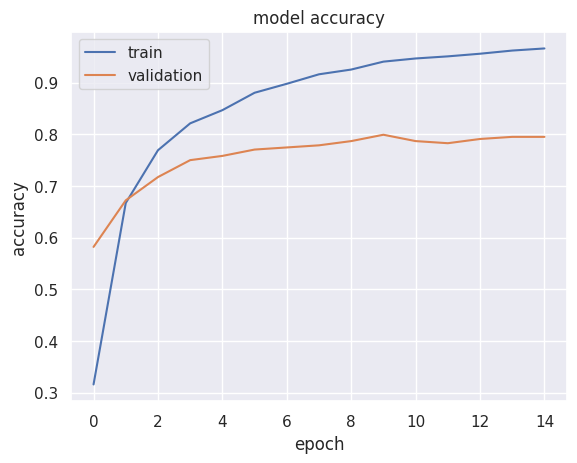

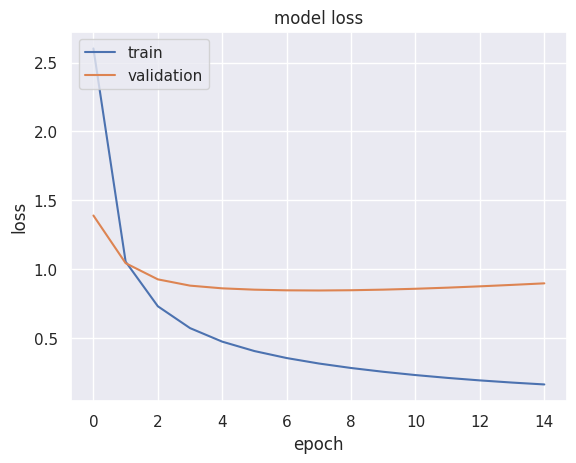

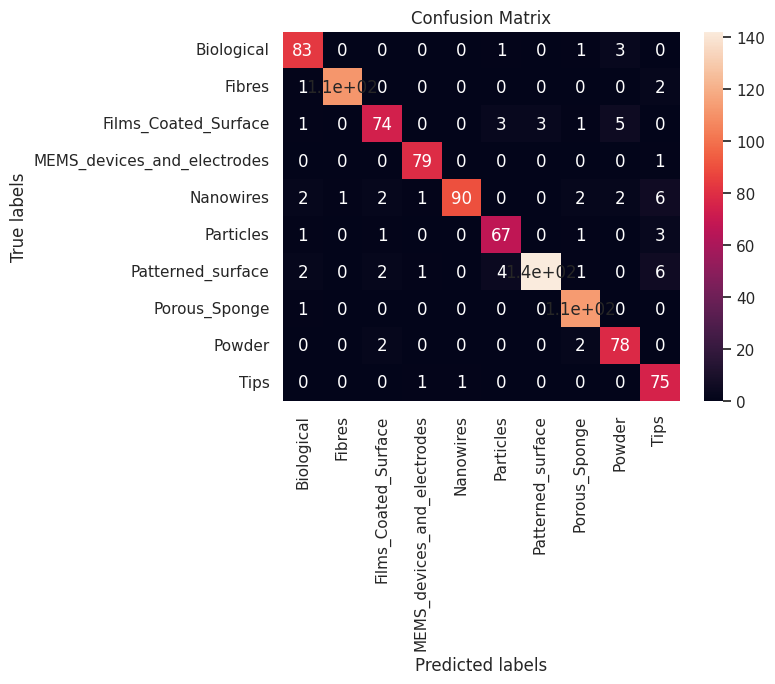

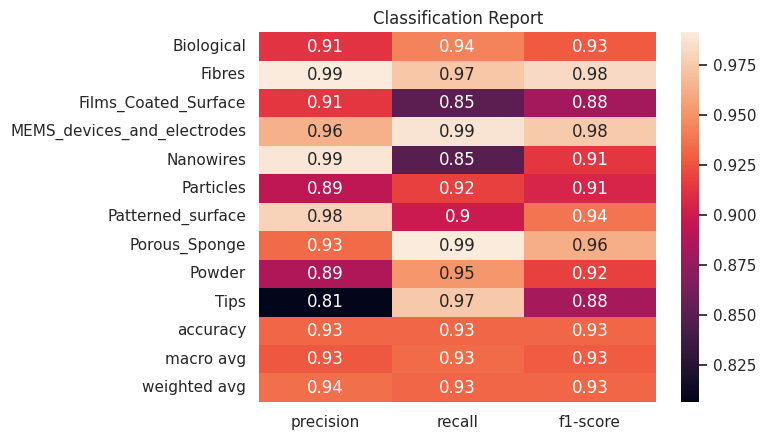

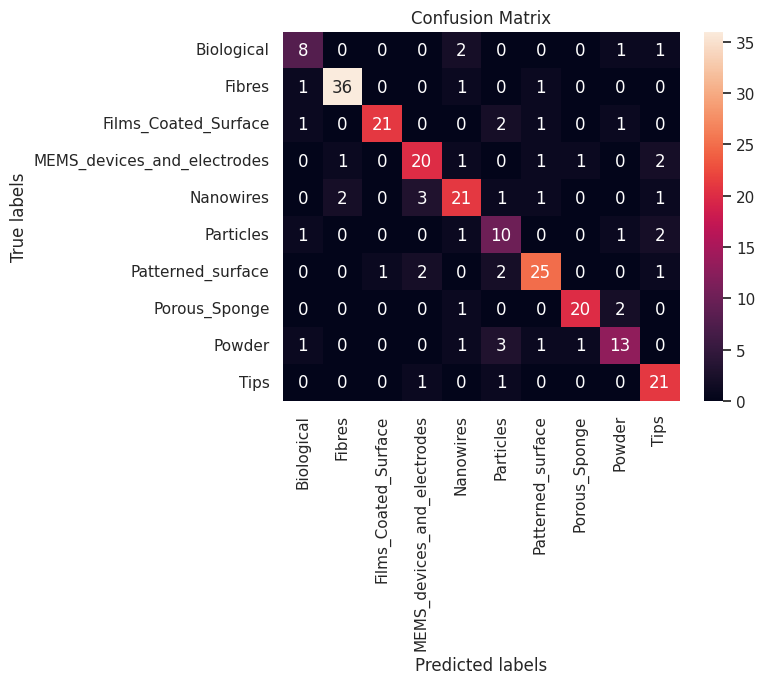

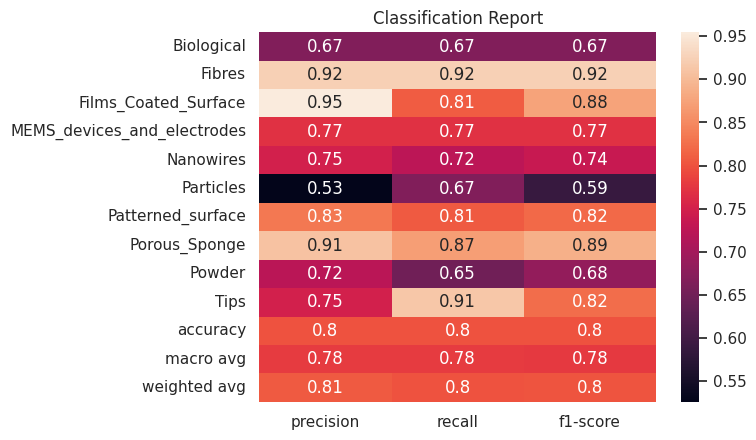

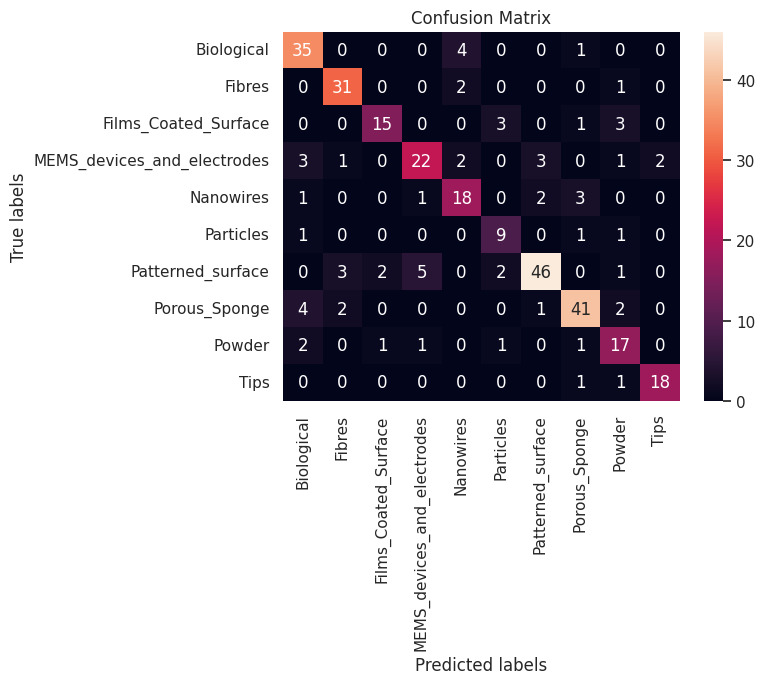

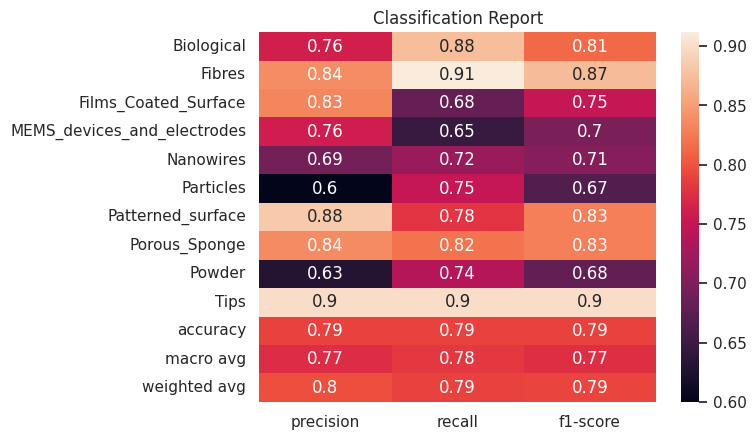

In [ ]:
evaluatedModel(model)

In [ ]:
saveHistoryAndFinalModel(model, modelSaveLocation, history, historySaveLocation)

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [ ]:
predicted_batch = model.predict(imagesBatch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = classNames[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 2s 2s/step
['Powder' 'Patterned_surface' 'MEMS_devices_and_electrodes' 'Nanowires'
 'Porous_Sponge' 'MEMS_devices_and_electrodes' 'Fibres' 'Particles'
 'Biological' 'Nanowires' 'Tips' 'Nanowires' 'Fibres' 'Fibres' 'Powder'
 'Films_Coated_Surface' 'Porous_Sponge' 'Powder' 'Patterned_surface'
 'MEMS_devices_and_electrodes' 'MEMS_devices_and_electrodes' 'Biological'
 'Patterned_surface' 'Nanowires' 'Biological' 'Powder' 'Patterned_surface'
 'Biological' 'Powder' 'Powder' 'Porous_Sponge' 'Biological']


Plot the model predictions:

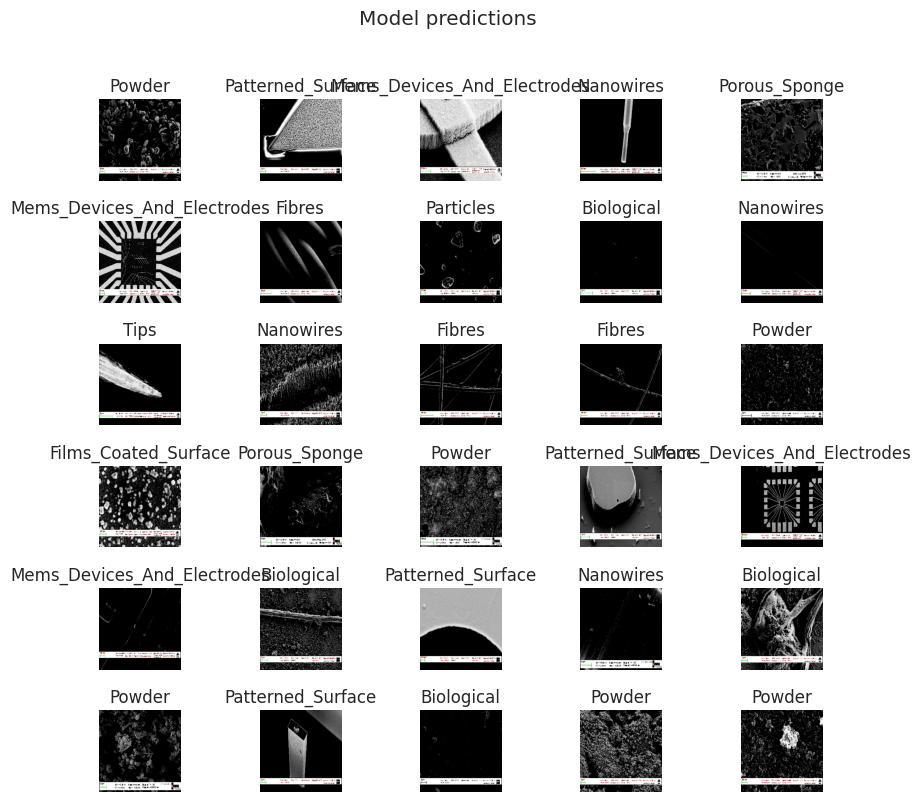

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(imagesBatch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [ ]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

'/tmp/saved_models/1681685942'

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
resultsBatch = model.predict(imagesBatch)
reloaded_resultsBatch = reloaded.predict(imagesBatch)

1/1 [==============================] - 4s 4s/step


In [ ]:
abs(reloaded_resultsBatch - resultsBatch).max()

0.0

In [ ]:
reloaded_predicted_id = tf.math.argmax(reloaded_resultsBatch, axis=-1)
reloaded_predicted_label_batch = classNames[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['Powder' 'Patterned_surface' 'MEMS_devices_and_electrodes' 'Nanowires'
 'Porous_Sponge' 'MEMS_devices_and_electrodes' 'Fibres' 'Particles'
 'Biological' 'Nanowires' 'Tips' 'Nanowires' 'Fibres' 'Fibres' 'Nanowires'
 'Particles' 'Porous_Sponge' 'Powder' 'Patterned_surface'
 'MEMS_devices_and_electrodes' 'MEMS_devices_and_electrodes' 'Biological'
 'Patterned_surface' 'Nanowires' 'Biological' 'Powder' 'Patterned_surface'
 'Biological' 'Powder' 'Powder' 'Porous_Sponge' 'Porous_Sponge']


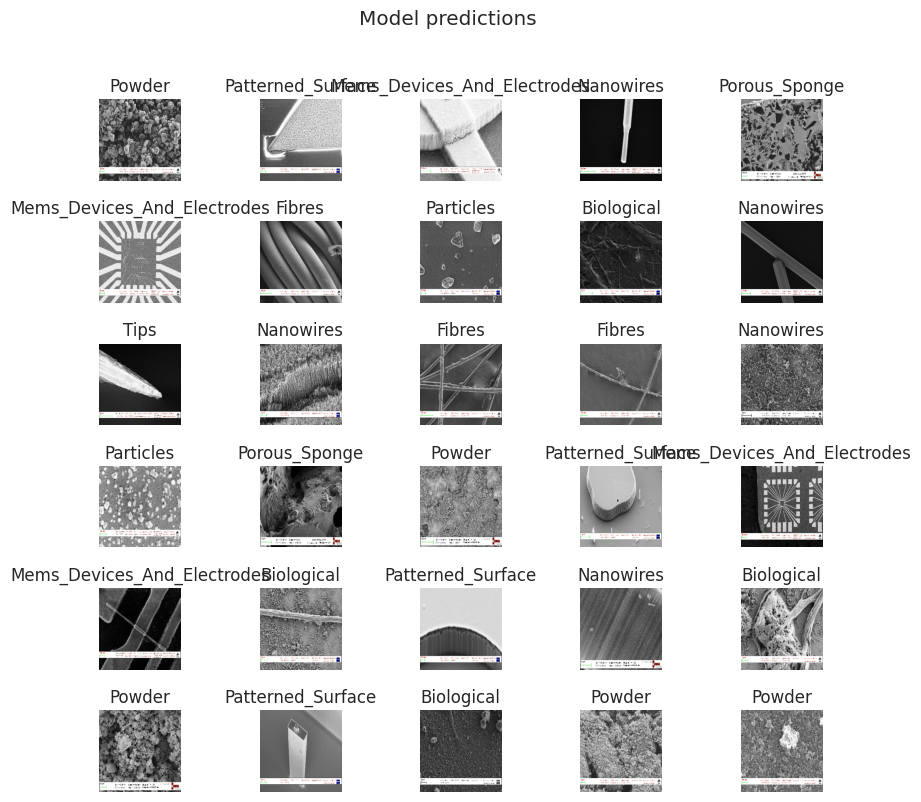

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(imagesBatch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Next steps

You can use the SavedModel to load for inference or convert it to a [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/)  model (for on-device machine learning) or a [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) model (for machine learning in JavaScript).

Discover [more tutorials](https://www.tensorflow.org/hub/tutorials) to learn how to use pre-trained models from TensorFlow Hub on image, text, audio, and video tasks.